
# Vanilla PnP for computed tomography (CT).

This example shows how to use a standart PnP algorithm with DnCNN denoiser for computed tomography.


In [1]:
import deepinv as dinv
from pathlib import Path
import torch
from deepinv.models import DnCNN
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves

c:\Users\jbhim\miniconda3\envs\altegrad\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup paths for data loading and results.




In [2]:
BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"

## Load image and parameters



In [3]:
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
# Set up the variable to fetch dataset and operators.
method = "PnP"
img_size = 32
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
operation = "tomography"

Selected GPU 0 with 5979 MB free memory 


## Set the forward operator
We use the :class:`deepinv.physics.Tomography`
class from the physics module to generate a CT measurements.



In [4]:
noise_level_img = 0.03  # Gaussian Noise standard deviation for the degradation
n_channels = 1  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.Tomography(
    img_width=img_size,
    angles=100,
    circle=False,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers = 4 if torch.cuda.is_available() else 0

## Set up the PnP algorithm to solve the inverse problem.
We use the Proximal Gradient Descent optimization algorithm.
The algorithm alternates between a denoising step and a gradient descent step.
The denoising step is performed by a DNCNN pretrained denoiser :class:`deepinv.models.DnCNN`.

Set up the PnP algorithm parameters : the ``stepsize``, ``g_param`` the noise level of the denoiser
and ``lambda`` the regularization parameter. The following parameters have been chosen manually.



In [5]:
# Logging parameters
verbose = True
plot_metrics = True  # compute performance and convergence metrics along the algorithm, curved saved in RESULTS_DIR

params_algo = {"stepsize": 1.0, "g_param": noise_level_img, "lambda": 0.01}
max_iter = 100
early_stop = True

# Select the data fidelity term
data_fidelity = L2()

# Specify the denoising prior
denoiser = DnCNN(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    train=False,
    device=device,
)
prior = PnP(denoiser=denoiser)

# instantiate the algorithm class to solve the IP problem.
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
)

Downloading: "https://huggingface.co/deepinv/dncnn/resolve/main/dncnn_sigma2_gray.pth?download=true" to C:\Users\jbhim/.cache\torch\hub\checkpoints\dncnn_sigma2_gray.pth
100%|██████████| 2.55M/2.55M [00:00<00:00, 16.6MB/s]


## Evaluate the model on the problem and plot the results.

The model returns the output and the metrics computed along the iterations.
For computing PSNR, the ground truth image ``x_gt`` must be provided.



Linear reconstruction PSNR: -16.02 dB
PnP reconstruction PSNR: 30.03 dB


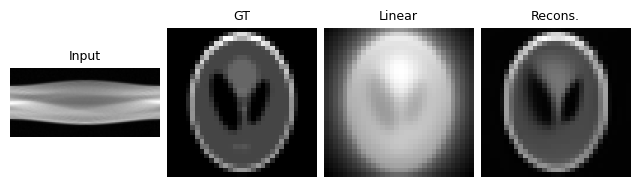

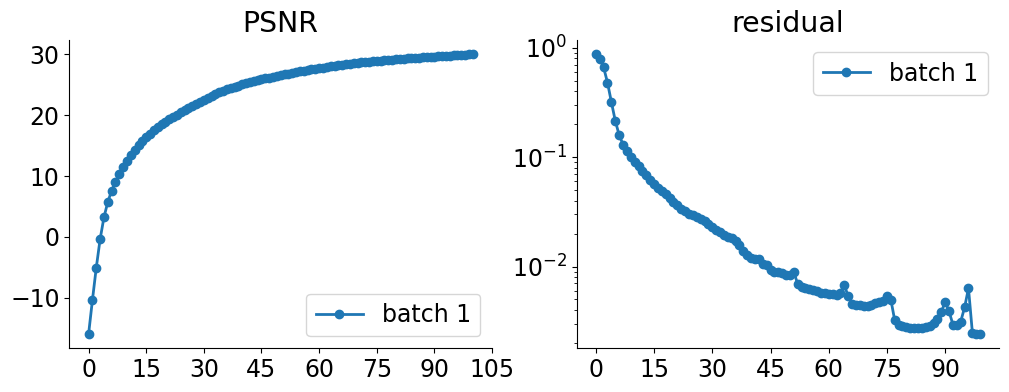

In [6]:
y = physics(x)
x_lin = physics.A_adjoint(y)  # linear reconstruction with the adjoint operator

# run the model on the problem.
x_model, metrics = model(
    y, physics, x_gt=x, compute_metrics=True
)  # reconstruction with PnP algorithm

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(f"PnP reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_model):.2f} dB")

# plot images. Images are saved in RESULTS_DIR.
imgs = [y, x, x_lin, x_model]
plot(
    imgs,
    titles=["Input", "GT", "Linear", "Recons."],
    save_dir=RESULTS_DIR / "images",
    show=True,
)

# plot convergence curves. Metrics are saved in RESULTS_DIR.
if plot_metrics:
    plot_curves(metrics, save_dir=RESULTS_DIR / "curves", show=True)